# Лаборная работа 2

## 1. Методы понижения дисперсии оценок

### Задание 1

Пусть имеется $n+m$ клеток некоторой ткани. При этом клетки $1, \ldots, n$ являются злокачественными, а клетки $n+1, \ldots, n+m$ - здоровыми. В результате проведения терапии клетка $i=1, \ldots, n+m$ погибает через время $T_i$, имеющее показательное распределение с параметром $\lambda_i$. Случайные величины $T_1, \ldots, T_{n+m}$ предполагаются независимыми. Пусть в некоторый момент времени все злокачественные клетки погибли, требуется вычислить оценку вероятности того, что число оставшихся здоровых клеток $N$ превысит некоторое заданное значение $k$:  
$$\mathbb{P}(N \geq k)=\mathbb{P}\left(\max _{i \leq n} T_i<T^{(k)}\right)$$

где $T^{(k)}-k$-ая по величине из значений $T_{n+1}, \ldots, T_{n+m}$, т. е.
$$T^{(1)} \geq T^{(2)} \geq \cdots \geq T^{(k)} \geq \cdots \geq T^{(m)}$$

Для оценки искомой вероятности воспользоваться условным методом МонтеКарло, предварительно получив выражение для условной вероятности
$$\mathbb{P}\left(N \geq k \mid T^{(k)}\right)$$

In [1]:
import numpy as np

# Параметры задачи
n = 5  # Количество злокачественных клеток
m = 20  # Количество здоровых клеток
k = 10  # Минимальное количество оставшихся здоровых клеток
lambdas_malignant = np.random.uniform(0.1, 0.5, n)  # Параметры λ для злокачественных клеток
lambdas_healthy = np.random.uniform(0.05, 0.4, m)  # Параметры λ для здоровых клеток

# Количество экспериментов Монте-Карло
N_experiments = 10000

In [2]:
# Проверка входных данных
assert len(lambdas_malignant) == n, "Длина lambdas_malignant должна быть равна n"
assert len(lambdas_healthy) == m, "Длина lambdas_healthy должна быть равна m"
assert k <= m, "k не может быть больше m"

# Счетчик для оценки вероятности
conditional_probabilities = np.zeros(N_experiments)

for i in range(N_experiments):
    # Генерация времен гибели здоровых клеток
    healthy_times = np.random.exponential(scale=1 / np.array(lambdas_healthy))

    # Нахождение k-й порядковой статистики (T^(k))
    t_k = np.partition(healthy_times, -k)[-k]

    # Вычисление условной вероятности P(N >= k | T^(k))
    prob = np.prod(1 - np.exp(-np.array(lambdas_malignant) * t_k))
    conditional_probabilities[i] = prob

# Оценка вероятности P(N >= k) как среднее условных вероятностей
probability_estimate = np.mean(conditional_probabilities)
print(f"Оценка вероятности P(N >= k): {probability_estimate:.6f}")

Оценка вероятности P(N >= k): 0.118897


### Задание 2

Рассматриваются случайные блуждания без самопересечений (SAW - Self-Avoiding Walk) на неограниченной двумерной целочисленной решетке, стартующие с начала координат (см. рис. 1). Найти оценку среднего расстояния от начала координат до финальной точки блуждания заданной длины 𝑛 с помощью метода существенной выборки.  
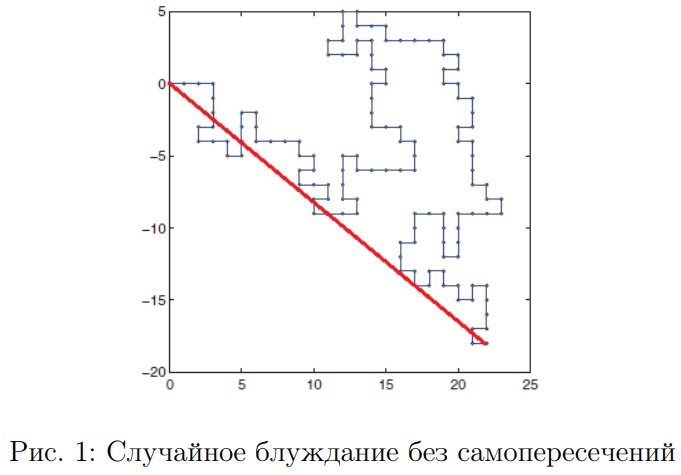

In [3]:
# Направления: вверх, вниз, влево, вправо
directions = [(0, 1), (0, -1), (-1, 0), (1, 0)]

In [4]:
# Функция для моделирования SAW
def simulate_saw(n):
    visited = set()
    path = [] 
    current = (0, 0)
    visited.add(current)
    path.append(current)
    
    for _ in range(n):
        # Возможные следующие шаги
        possible_steps = []
        for dx, dy in directions:
            next_pos = (current[0] + dx, current[1] + dy)
            if next_pos not in visited:
                possible_steps.append(next_pos)
        
        # Если нет возможных шагов, блуждание завершено
        if not possible_steps:
            break
        
        # Выбор следующего шага (равномерное распределение)
        next_pos = possible_steps[np.random.randint(len(possible_steps))]
        visited.add(next_pos)
        path.append(next_pos)
        current = next_pos
    
    return path

In [5]:
def simulate_saw_importance(n):
    visited = set()
    path = []
    current = (0, 0)
    visited.add(current)
    path.append(current)
    
    for _ in range(n):
        # Возможные следующие шаги
        possible_steps = []
        weights = []
        for dx, dy in directions:
            next_pos = (current[0] + dx, current[1] + dy)
            if next_pos not in visited:
                possible_steps.append(next_pos)
                # Вес: увеличиваем вероятность шагов, удаляющих от начала
                distance = np.sqrt(next_pos[0]**2 + next_pos[1]**2)
                weights.append(distance)
        
        # Если нет возможных шагов, блуждание завершено
        if not possible_steps:
            break
        
        # Нормализация весов
        weights = np.array(weights)
        weights /= weights.sum()

        # Выбор следующего шага с учетом весов
        next_pos = possible_steps[np.random.choice(len(possible_steps), p=weights)]
        visited.add(next_pos)
        path.append(next_pos)
        current = next_pos
    
    return path

In [6]:
import random
import matplotlib.pyplot as plt

# Функция для визуализации SAW
def plot_saw(paths):
    plt.figure(figsize=(10, 8))
    
    for i, path in enumerate(paths):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)

        x = [p[0] for p in path]
        y = [p[1] for p in path]
        
        # Отрисовка пути
        plt.plot(x, y, marker='o', linestyle='-', color="#{:02x}{:02x}{:02x}".format(r, g, b), markersize=5)#, label=f'Путь №{i+1}')
        
        # Отрисовка линии расстояния от начала до конечной точки
        plt.plot([0, path[-1][0]], [0, path[-1][1]], linestyle='--', color="#{:02x}{:02x}{:02x}".format(r, g, b), alpha=0.5)#, label=f'Расстояние №{i+1}')
        
    plt.title(f"Случайное блуждание без самопересечений длины N={n}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    # plt.legend()
    plt.show()

In [7]:
import numpy as np

def simulate(n, N_samples, saw_function):
    paths = []
    distances = []

    for _ in range(N_samples):
        path = saw_function(n)
        paths.append(path)
        
        # Вычисление расстояния до конечной точки
        final_pos = path[-1]
        distance = np.sqrt(final_pos[0]**2 + final_pos[1]**2)  # Евклидово расстояние
        distances.append(distance)

    # Оценка среднего расстояния
    average_distance = sum(distances) / N_samples
    print(f"Оценка среднего расстояния обычным SAW: {average_distance:.4f}")
    plot_saw(paths)

Оценка среднего расстояния обычным SAW: 14.3543


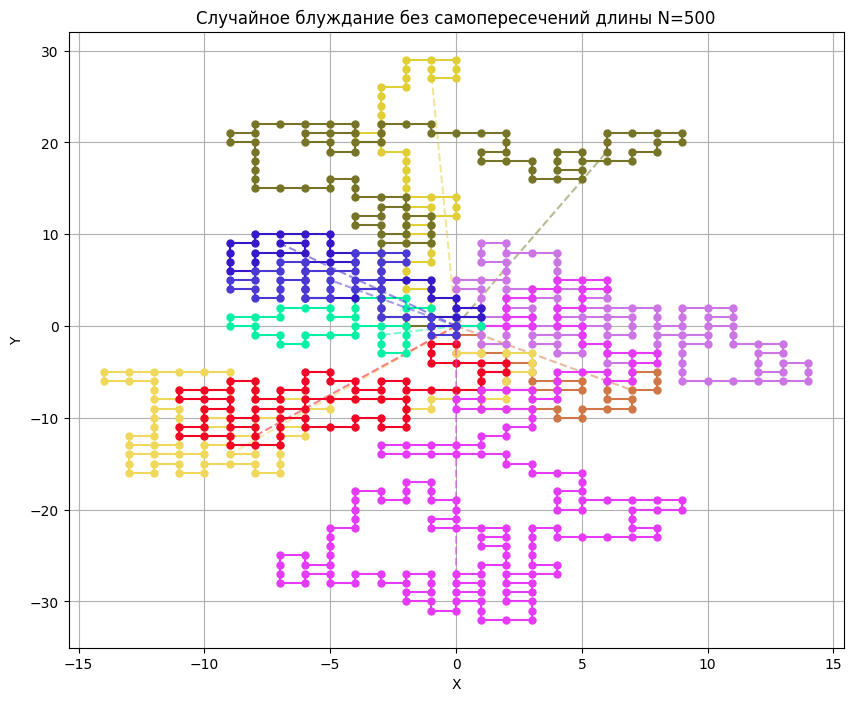

Оценка среднего расстояния обычным SAW: 13.2535


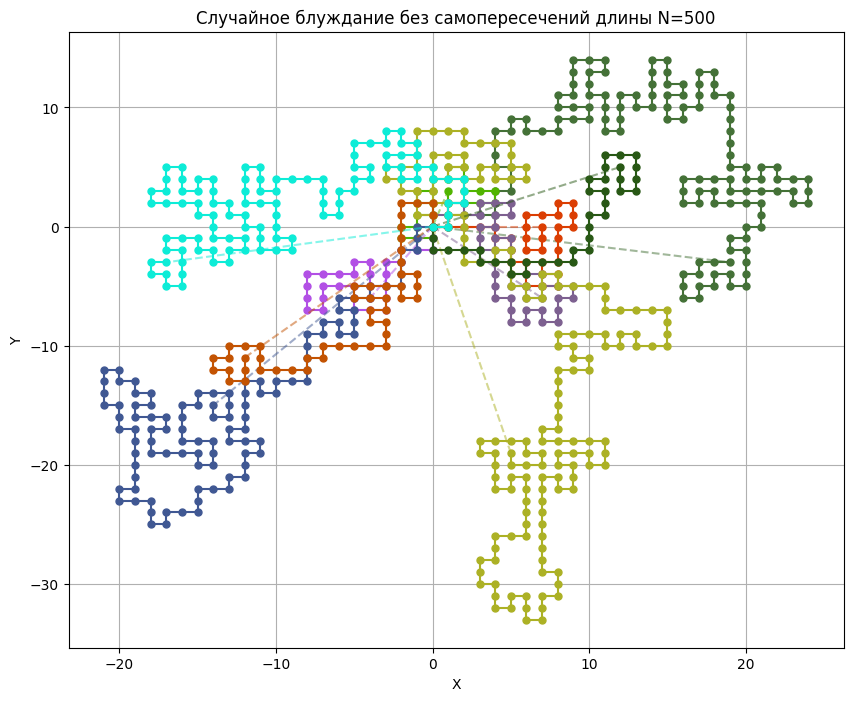

In [8]:
# Параметры задачи
n = 500  # Длина SAW
N_samples = 10 # Количество SAW для моделирования

# Моделирование обычного SAW и визуализация
simulate(n, N_samples, simulate_saw)

# Моделирование SAW с методом существенной выборки и визуализация
simulate(n, N_samples, simulate_saw_importance)

## 2. Моделирование распространения излучения в многослойных средах

Рассматривается процесс распространения излучения в многослойных биологических тканях с оптическими параметрами, близкими к коже и подкожным тканям. Каждый слой характеризуется своим набором параметров: коэффициентом поглощения $\mu_a$, коэфициентом рассеяния $\mu_s$, фактором анизотропии $g$, толщиной $d$. Предполагается, что ткань содержит внутреннюю замкнутую неоднородность в виде шара радиуса $r$ с центром, расположенным на глубине $\ell$ от поверхности.  
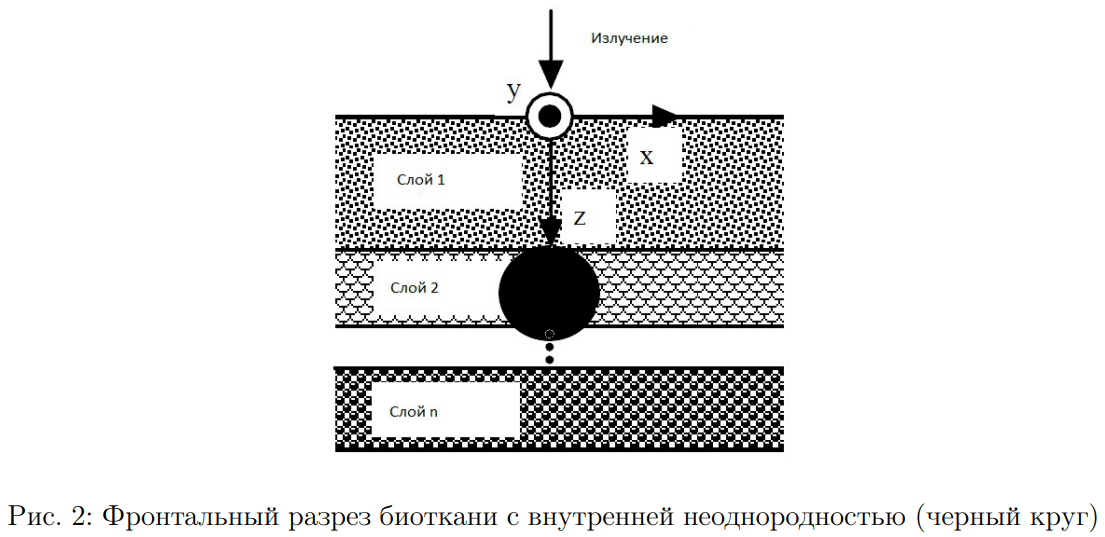  
На поверхность биоткани падает (перпендикулярно поверхности) бесконечно тонкий световой пучок, так что направление падения пучка проходит через центр внутренней неоднородности (см. рис. 2 ). Оптические свойства биоткани представлены в таблице 1. 
   
\begin{aligned}
&\text { Таблица 1: Оптические параметры модели кожи для длины волны } \lambda=337 \text { нм }\\
&\begin{array}{|c|l|c|c|c|c|}
\hline \text { № } & \text { Слой } & \mu_a, \mathrm{~cm}^{-1} & \mu_s, \mathrm{~cm}^{-1} & g & d, \mathrm{~cm} \\
\hline 1 & \text { Эпидермис } & 32 & 165 & 0,72 & 0,01 \\
2 & \text { Папиллярная дерма } & 23 & 227 & 0,72 & 0,02 \\
3 & \text { Поверхностное сосудистое сплетение } & 40 & 246 & 0,72 & 0,02 \\
4 & \text { Ретикулярная дерма } & 23 & 227 & 0,72 & 0,09 \\
5 & \text { Глубокое сосудистое сплетение } & 46 & 253 & 0,72 & 0,06 \\
6 & \text { Неоднородность } & 51 & 186 & 0,8 & - \\
\hline
\end{array}
\end{aligned}
  
Моделирование распространения фотонов в многослойных средах проводится по
стандартной схеме [3]. При столкновении со структурными элементами биоткани фотоны могут рассеиваться или поглощаться. Вероятность поглощения равна  
$$
P_a=\frac{\mu_a}{\mu_a+\mu_s}
$$

Когда фотон рассеивается, его траектория отклоняется на угол $\theta \in[0, \pi]$. Плотность распределения с. в. $\cos \theta$ определяется так называемой фазовой функцией ХениГринштейна:
$$
p(\cos \theta)=\frac{1-g^2}{2\left(1+g^2-2 g \cos \theta\right)^{3 / 2}}
$$

где $g$ - фактор анизотропии. Также предполагается, что фотон отклоняется аксиальносимметрично относительно первоначального направления на азимутальный угол $\varphi \in[0,2 \pi]$. Пробег фотона между взаимодействиями распределен по показательному закону с параметром $\mu=\mu_a+\mu_s$ (для простоты предположим, что при прохождении через границу разделения слоев разыгрывать новую длину пробега не требуется). Отражения на границах слоев биоткани не учитываются.  

Каждому фотону приписывается статистический вес $W=1$. При очередном акте взаимодействия со средой статистический вес уменьшается на величину  
$$
\Delta W=W \frac{\mu_a}{\mu}
$$

Если статистический вес достиг порогового значения $W_{\text {П }}$, то с вероятностью $1 / m$ фотон может продолжить движение с новым весом $m W$, в противном случае фотон считается поглощенным. Поглощенная энергия, приходящаяся на некоторый участок биоткани, находится по следующей формуле
$$
Q=\frac{X q}{V}
$$

где $X$ - суммарный статистический вес, поглощенный на данном участке объема $V$; $q$ - энергия, которой соответствует полный статистический вес пакета фотонов.

Смоделировать траекторию движения $N$ фотонов и вычислить оценки следующих характеристик:
1. Коэффициенты пропускания (доля фотонов, прошедших через ткань) и отражения (доля отраженных фотонов) среды;
2. Распределение поглощенной энергии в плоскости сечения $x z$.

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt


# Оптические параметры слоёв
layers = [
    {"mu_a": 32, "mu_s": 165, "g": 0.72, "d": 0.01},
    {"mu_a": 23, "mu_s": 227, "g": 0.72, "d": 0.02},
    {"mu_a": 40, "mu_s": 246, "g": 0.72, "d": 0.02},
    {"mu_a": 23, "mu_s": 227, "g": 0.72, "d": 0.09},
    {"mu_a": 46, "mu_s": 253, "g": 0.72, "d": 0.06}
]

# Параметры неоднородности (сфера)
inhomogeneity = {"mu_a": 51, "mu_s": 186, "g": 0.8}
radius = 0.04
depth = 0.07

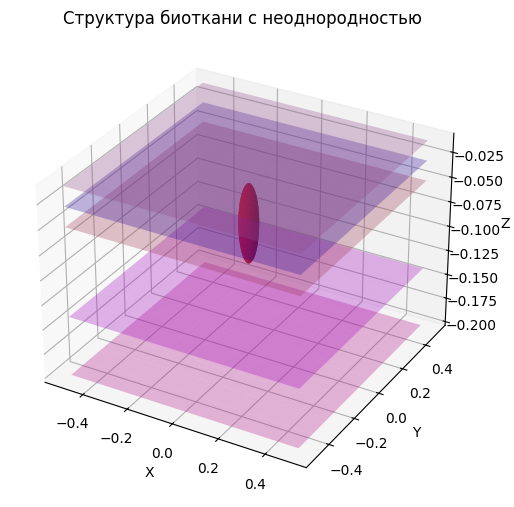

In [10]:
# Визуализация слоёв
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(111, projection='3d')

z_start = 0
for layer in layers:
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    
    z_end = z_start - layer["d"]
    x = np.linspace(-0.5, 0.5, 10)
    y = np.linspace(-0.5, 0.5, 10)
    X, Y = np.meshgrid(x, y)
    Z = np.full_like(X, z_end)
    ax.plot_surface(X, Y, Z, color="#{:02x}{:02x}{:02x}".format(r, g, b), alpha=0.3)
    z_start = z_end

# Визуализация сферы
u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)
x_s = radius * np.outer(np.cos(u), np.sin(v))
y_s = radius * np.outer(np.sin(u), np.sin(v))
z_s = radius * np.outer(np.ones(np.size(u)), np.cos(v)) - depth
ax.plot_surface(x_s, y_s, z_s, color='r', alpha=1.0)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Структура биоткани с неоднородностью")
plt.show()

In [11]:
def is_inside_sphere(x, y, z):
    r_squared = radius ** 2
    distance_squared = (x ** 2) + (y ** 2) + (z - depth) ** 2
    return distance_squared <= r_squared


def monte_carlo_simulation(N, W_threshold, m):
    transmitted = 0
    reflected = 0
    absorbed_energy = np.zeros((100, 100))  # Матрица поглощенной энергии
    
    total_thickness = sum(layer["d"] for layer in layers)  # Суммарная толщина ткани
    
    for _ in range(N):
        x, y, z = 0, 0, 0
        W = 1
        direction = np.array([0, 0, 1])

        while True:
            # Проверка, находится ли фотон внутри шара
            if is_inside_sphere(x, y, z):
                current_layer = inhomogeneity
            else:
                # Определение текущего слоя ткани
                current_layer = None
                total_depth = 0
                for layer in layers:
                    total_depth += layer["d"]
                    if z < total_depth:
                        current_layer = layer
                        break

            if current_layer is None:
                transmitted += 1
                break

            # Длина пробега
            mu = current_layer["mu_a"] + current_layer["mu_s"]
            step = -np.log(np.random.rand()) / mu

            # Обновление положения
            x_new = x + step * direction[0]
            y_new = y + step * direction[1]
            z_new = z + step * direction[2]

            # Проверка на выход за пределы ткани
            if z_new < 0:
                reflected += 1
                break
            if z_new > total_thickness:
                transmitted += 1
                break

            # Поглощение
            W -= W * current_layer["mu_a"] / mu
            
            # Фиксация поглощенной энергии
            ix = int((x_new + 5) * 10)
            iy = int((z_new + 5) * 10)
            if 0 <= ix < 100 and 0 <= iy < 100:
                absorbed_energy[ix, iy] += W

            # Проверка на пороговый вес
            if W < W_threshold:
                if np.random.rand() < 1 / m:
                    W *= m
                else:
                    break

            # Взаимодействие
            if np.random.rand() < current_layer["mu_a"] / mu:
                continue
            else:
                # Рассеяние
                cos_theta = (1 + current_layer["g"] ** 2 - ((1 - current_layer["g"] ** 2) / (1 - current_layer["g"] + 2 * current_layer["g"] * np.random.rand())) ** 2) / (2 * current_layer["g"])
                sin_theta = np.sqrt(1 - cos_theta ** 2)
                phi = 2 * np.pi * np.random.rand()
                direction = np.array([
                    sin_theta * np.cos(phi),
                    sin_theta * np.sin(phi),
                    cos_theta
                ])

            # Обновление положения
            x, y, z = x_new, y_new, z_new
    
    return transmitted / N, reflected / N, absorbed_energy

In [12]:
T, R, Q = monte_carlo_simulation(
    N=1000,                 # количество фотонов
    W_threshold = 1e-7,      # пороговый вес фотона
    m = 3
)
print(f"Коэффициент пропускания: {T:.4f}")
print(f"Коэффициент отражения: {R:.4f}")


Коэффициент пропускания: 0.7860
Коэффициент отражения: 0.0460


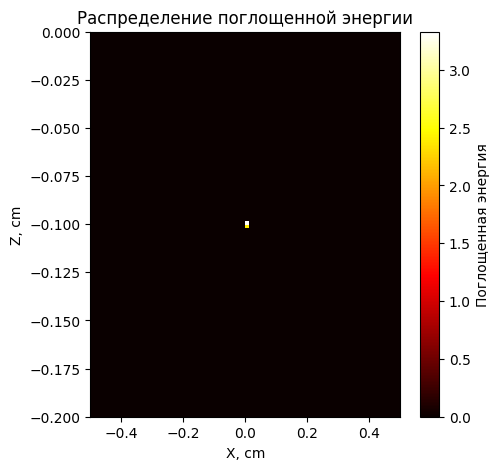

In [13]:
# Визуализация поглощенной энергии
plt.figure(figsize=(5, 5))
plt.imshow(Q/1000, extent=[-0.5, 0.5, -sum(l["d"] for l in layers), 0], origin='lower', cmap='hot', aspect='auto')
plt.colorbar(label='Поглощенная энергия')
plt.xlabel("X, cm")
plt.ylabel("Z, cm")
plt.title("Распределение поглощенной энергии")
plt.show()